In [14]:
%matplotlib inline
import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/dalia_individual_windows_20.p','rb'))

In [15]:
X = X[:,:,1:]*64

activity_dict_dalia = {0:'No Label',
                1:'Sitting',
                2:'Stairs',
                3:'Soccer',
                4:'Cycling',
                5:'Driving',
                6:'Lunch',
                7:'Walking',
                8:'Working'}
activity_list = ['Stationery','Stairs','Exercise','Walking','Sports']
activity_dict_dalia_transformation = {0:-1,
                1:0,
                2:1,
                3:-1,
                4:2,
                5:0,
                6:-1,
                7:3,
                8:-1}
y_activity = np.array([activity_dict_dalia_transformation[a] for a in y_activity])
X  = X[y_activity>-1]
y_activity = y_activity[y_activity>-1]

from scipy.interpolate import interp1d
def interpolate_acl(a,window_size=20,fs_now=32,fs_new=20):
    x_now = np.linspace(0,window_size,window_size*fs_now)
    f = interp1d(x_now,a,axis=0,fill_value='extrapolate')
    x_new = np.linspace(0,window_size,window_size*fs_new)
    return f(x_new)
X = np.array([interpolate_acl(a) for a in X])

Fs = 20
window_size = 20
n_timesteps = window_size*Fs
X = X[:,:,:].reshape(-1,n_timesteps,3)
X[X<-2] = -2
X[X>2] = 2

In [19]:
X_magnitude = np.array([np.sqrt(np.sum(np.square(a),axis=1)) for a in X])

In [20]:
X = X_magnitude.reshape(-1,n_timesteps,1)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
# import numpy as np
# %matplotlib notebook
from tensorflow.keras.layers import Conv1D,BatchNormalization,Dropout,Input,MaxPooling1D,Flatten,Dense,Input
from tensorflow.keras.models import Model, Sequential

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPU


In [22]:
import tensorflow_addons as tfa
def get_model(input_shape=(200,1),act='tanh',loss="mae",opt='adam',n_classes=1):
    model =  Sequential()
    model.add(Conv1D(100,10,input_shape=input_shape,activation='linear',kernel_initializer='normal',padding='same'))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(200,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(50,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(4))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(n_classes*20,activation='relu',kernel_initializer='normal'))
#     model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='embedding'))
    model.add(Dense(n_classes,activation=None,kernel_initializer='normal'))
    model.add(Dense(n_classes,activation='softmax',kernel_initializer='normal'))
    model.compile(loss=loss,optimizer=opt)
    return model
from focal_loss import BinaryFocalLoss,SparseCategoricalFocalLoss
model =  get_model(input_shape=(n_timesteps,1),n_classes=len(np.unique(y_activity)),loss=SparseCategoricalFocalLoss(gamma=2))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 400, 100)          1100      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 400, 100)          100100    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 200, 100)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 200, 100)          400       
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 200, 100)          100100    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 100, 100)         

In [23]:
from keras.models import load_model
n_classes = len(np.unique(y_activity))
model =  get_model(input_shape=(n_timesteps,1),n_classes=n_classes,loss=SparseCategoricalFocalLoss(gamma=1))
filepath = '../model_files/activity_estimator_dalia_magnitude_final_5_labels.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
train_x,test_x,train_y,test_y = train_test_split(X,y_activity,test_size=.3,stratify=y_activity)
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=.2,stratify=train_y)
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=300, batch_size=100,verbose=1,
      callbacks=callbacks_list,shuffle=True)

Epoch 1/300
52/52 [==============================] - 2s 28ms/step - loss: 0.6221 - val_loss: 1.2596

Epoch 00001: val_loss improved from inf to 1.25958, saving model to ../model_files/activity_estimator_dalia_magnitude_final_5_labels.hdf5
Epoch 2/300
52/52 [==============================] - 1s 19ms/step - loss: 0.1694 - val_loss: 1.5981

Epoch 00002: val_loss did not improve from 1.25958
Epoch 3/300
52/52 [==============================] - 1s 19ms/step - loss: 0.1125 - val_loss: 5.6739

Epoch 00003: val_loss did not improve from 1.25958
Epoch 4/300
52/52 [==============================] - 1s 19ms/step - loss: 0.0815 - val_loss: 4.3569

Epoch 00004: val_loss did not improve from 1.25958
Epoch 5/300
52/52 [==============================] - 1s 19ms/step - loss: 0.1139 - val_loss: 0.8408

Epoch 00005: val_loss improved from 1.25958 to 0.84081, saving model to ../model_files/activity_estimator_dalia_magnitude_final_5_labels.hdf5
Epoch 6/300
52/52 [==============================] - 1s 19ms/s

In [24]:
model.load_weights(filepath)
y_pred = model.predict(test_x).argmax(axis=1)

In [25]:
from sklearn.metrics import confusion_matrix

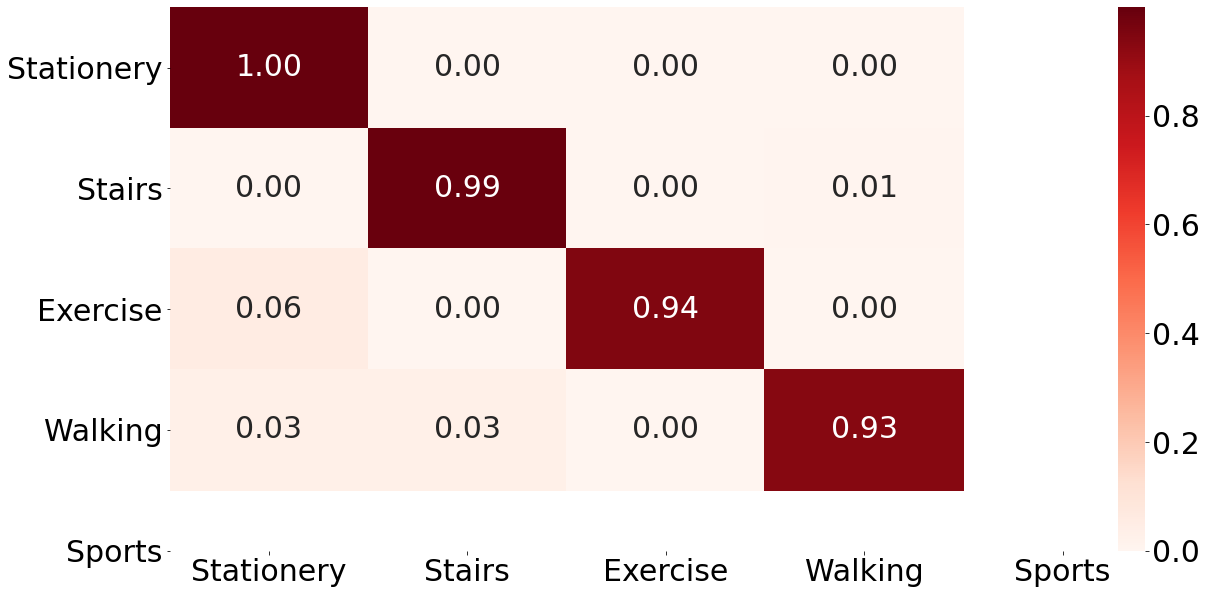

In [26]:

activity_list = ['Stationery','Stairs','Exercise','Walking','Sports']
import seaborn as sns
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(test_y,y_pred,normalize='true'),annot=True,cmap='Reds',fmt='.2f')
plt.xticks(np.arange(.5,len(activity_list)+.5,1),activity_list)
plt.yticks(np.arange(.5,len(activity_list)+.5,1),activity_list,rotation=0)
plt.show()